In [1]:
import numpy as np
import matplotlib.pyplot as plt
from emnist import extract_training_samples
from functools import partial

from vertices_generator import vertices
from kernel import Gaussian_kernel
from mdwsvm_ad import mdwsvm_ad
from mdwsvm import mdwsvm
from one_class_svm import one_class_svm
from hybrid import hybrid
from metric import within_class_error

In [2]:
# Load data
digits_images, digits_labels = extract_training_samples('digits')
letters_images, letters_labels = extract_training_samples('byclass')

X_train = np.zeros((4000,28,28))
y_train = np.zeros((4000), dtype=int)
X_test = np.zeros((40000,28,28))
y_test = np.zeros((40000), dtype=int)

# 4000 digits normalized training data 
X_train[0:4000,:,:] = digits_images[0:4000,:,:] / 255
X_train = X_train.reshape(4000,784).T 
y_train[0:4000] = digits_labels[0:4000] # 4000 digits training label

# Get 2000 digits for test X
X_test[0:2000,:,:] = digits_images[4000:6000,:,:] / 255
y_test[0:2000] = digits_labels[4000:6000]
# Get 38000 lowercase letters
count = 2000
current_i = 0
while True:
    if count == 40000:
        break

    if(letters_labels[current_i] >= 36): # Get lower case letter
        X_test[count,:,:] = letters_images[current_i,:,:] / 255
        y_test[count] = letters_labels[current_i]
        count += 1

    current_i += 1
# 2000 digits and 38000 letters normalized data, 0-9 are 0-9, 36-61 are a-z
X_test = X_test.reshape(40000,784).T

In [59]:
index_train = np.concatenate([np.where(y_train <=1)[0]]) # 0,1,2,3
X_train_2 = X_train[:, index_train]
y_train_2 = y_train[index_train]

index_test = np.concatenate([np.where(y_test <=1)[0], np.where(y_test == 46)[0]]) # 0,1,2,3, 46
X_test_2 = X_test[:, index_test]
y_test_2 = y_test[index_test]

In [23]:
np.unique(y_train_2, return_counts=True)

(array([0, 1, 2, 3]), array([406, 431, 396, 362]))

In [13]:
y_train_2.shape

(837,)

In [8]:
import numpy as np
import cvxpy as cp

class mdwsvm_ad:
    '''
    This class aims to reimplement MDWSVM to do multiclass classification

    Variables: 
            X:      training data matrix of interest (d by n) where n is the number of training samples and d is the number of features
            y:      training labels
            W:      vertices matrix for all classes: K by (K+1)
            C:      constraint hyperparameter on B which is the coefficient in f
            alp:    weighting parameter, the default value of 0.5
            v:      hyperparameter within (0,1)
            K:      kernel function defined in matrix form, the default is a radius-based Gaussian kernel
    '''

    def __init__(self, X, y, W, C, v, K, alp = 0.5):
        self.X = X
        self.y = y
        self.W = W
        self.C = C
        self.alp = alp
        self.v = v
        self.K = K
        self.d, self.e = self.fit()

    def fit(self):
        # TODO
        _, n = self.X.shape
        k, _ = self.W.shape
        W_y = self.W[:,self.y]
        _, counts = np.unique(self.y, return_counts=True)
        N_y = counts[self.y]
        # Calculate the train-train kernel matrix.
        G = self.K(self.X, self.X)

        d = cp.Variable(n)
        e = cp.Variable(n)
        f = cp.Variable(n)

        objective = cp.Minimize(0.5 * cp.sum([cp.quad_form(cp.multiply((d+e), W_y[j]), G) for j in range(k)])
                                -2 * cp.sum(cp.sqrt(self.C*self.alp*(d-f) / (self.v*N_y))))
        
        constraints = [W_y @ d == 0,
                       W_y @ e == 0,
                       cp.sum(e) == self.C,
                       # d - f > 0,
                       e <= self.C * (1-self.alp) / (self.v * N_y),
                       d <= self.C * self.alp / (self.v * N_y),
                       d - f >= 1e-16, 
                       e >= 0,
                       f >= 0]
        
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.SCS, verbose=True)

        return d.value, e.value        

    def predict(self, data):
        '''
        Input:
            data:  data matrix for prediction (d by m)

        Output:
            y:  predicted labels for data
        '''
        # TODO
        # Compute the train-test kernel matrix
        G = self.K(self.X, data)

        g = self.d + self.e
        W = self.W
        W_y = self.W[:,self.y]
        y = np.argmax(W.T @ ((np.diag(g) @ W_y.T).T @ G), axis=0)

        return y

In [103]:
import numpy as np
import cvxpy as cp

class mdwsvm_ad:
    '''
    This class aims to reimplement MDWSVM to do multiclass classification

    Variables: 
            X:      training data matrix of interest (d by n) where n is the number of training samples and d is the number of features
            y:      training labels
            W:      vertices matrix for all classes: K by (K+1)
            C:      constraint hyperparameter on B which is the coefficient in f
            alp:    weighting parameter, the default value of 0.5
            v:      hyperparameter within (0,1)
            K:      kernel function defined in matrix form, the default is a radius-based Gaussian kernel
    '''

    def __init__(self, X, y, W, U, C, v, K, alp = 0.5):
        self.X = X
        self.y = y
        self.W = W
        self.U = U
        self.C = C
        self.alp = alp
        self.v = v
        self.K = K
        self.d, self.e = self.fit()

    def fit(self):
        # TODO
        _, n = self.X.shape
        self.k, _ = self.W.shape
        W_y = self.W[:,self.y]
        U_y = self.U[:,self.y]
        _, counts = np.unique(self.y, return_counts=True)
        self.N_y = counts[self.y]
        # Calculate the train-train kernel matrix.
        G = self.K(self.X, self.X)

        d = cp.Variable(n)
        e = cp.Variable(n)
        f = cp.Variable(n)

        objective = cp.Minimize(0.5 * cp.sum([cp.quad_form(cp.multiply((d+e), W_y[j]), G) for j in range(self.k)])
                                -2 * cp.sum(cp.sqrt(self.C*self.alp*(d-f) / n))
                                + cp.sum(e)) 
        
        constraints = [W_y @ d == 0,
                       W_y @ e + (1-self.alp)*self.C*self.W[:,-1] == 0,
                       #cp.sum(e) == self.C * (1-self.alp),
                       e <= self.C * (1-self.alp) / (self.v * self.N_y),
                       d <= self.C * self.alp / n,
                       d - f >= 1e-16, 
                       e >= 0,
                       f >= 0]
        
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.SCS, verbose=True)

        return d.value, e.value        

    def predict(self, data):
        '''
        Input:
            data:  data matrix for prediction (d by m)

        Output:
            y:  predicted labels for data
        '''
        # TODO
        # Compute the train-test kernel matrix
        G = self.K(self.X, data)

        g = self.d + self.e
        W = self.W
        W_y = self.W[:,self.y]

        constant = np.zeros(self.k)
        index = np.where((self.e > 0) & (self.e < (1-self.alp)*self.C/(self.v*self.N_y)))[0]
        for i in range(self.k):
            selected_index = index[np.argmax(self.y[index] == i)]
            selected_G = self.K(self.X, self.X[:,selected_index].reshape(-1,1))
            constant[i] = 1 - W[:,i].T @ (np.diag(g) @ W_y.T).T @ selected_G

        constant_y = constant[self.y]
        constant = np.concatenate([constant, [np.dot(self.e, constant_y) / ((1-self.alp)*self.C)]]).reshape((-1,1))

        y = np.argmax(W.T @ ((np.diag(g) @ W_y.T).T @ G) + constant, axis=0)

        return y

In [86]:
np.arange(45).reshape(9,5)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34],
       [35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44]])

In [85]:
index = np.arange(9)
y = np.array([0,0,1,1,2,2,3,3,4])
np.arange(45).reshape(9,5) + y.reshape(-1,1)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20],
       [22, 23, 24, 25, 26],
       [27, 28, 29, 30, 31],
       [33, 34, 35, 36, 37],
       [38, 39, 40, 41, 42],
       [44, 45, 46, 47, 48]])

In [82]:
np.dot(y,y)

44

In [84]:
constant = np.zeros((5,1))
constant = np.concatenate([constant, [np.dot(y,y)]])
constant

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [76]:
index[np.argmax(y[index] == 1)]

2

In [72]:
np.where((e > 0) & (e < 8))

(array([1, 2, 3, 4, 5, 6, 7]),)

In [61]:
from vertices_generator_v2 import vertices_v2

In [104]:
v = 0.5
w1 = vertices(3)
w2 = vertices_v2(5)
c = 10
k = partial(Gaussian_kernel, sigma2=10)
model = mdwsvm_ad(X_train_2, y_train_2, w1, w2, c, v, k)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Apr 09 11:05:28 PM: Your problem has 2511 variables, 7 constraints, and 0 parameters.
(CVXPY) Apr 09 11:05:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 09 11:05:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 09 11:05:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 09 11:05:29 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 09 11:05:29 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/cvxpy/atoms/elementwise/power.py:181: RuntimeWarning: invalid value encountered in power
  return np.power(values[0], float(self.p.value))


In [105]:
G = model.K(model.X, X_test_2)

g = model.d + model.e
W = model.W
W_y = model.W[:,model.y]

constant = np.zeros(model.k)
index = np.where((model.e > 0) & (model.e < (1-model.alp)*model.C/(model.v*model.N_y)))[0]
for i in range(model.k):
    selected_index = index[np.argmax(model.y[index] == i)]
    selected_G = model.K(model.X, model.X[:,selected_index].reshape(-1,1))
    constant[i] = 1 - W[:,i].T @ (np.diag(g) @ W_y.T).T @ selected_G

constant_y = constant[model.y]
constant = np.concatenate([constant, [np.dot(model.e, constant_y) / ((1-model.alp)*model.C)]]).reshape((-1,1))

y = np.argmax(W.T @ ((np.diag(g) @ W_y.T).T @ G) + constant, axis=0)

In [106]:
np.unique(y, return_counts=True)

(array([1, 2]), array([117, 856]))

In [88]:
y_pred = model.predict(X_test_2)

In [107]:
np.unique(y[y_test_2 == 0], return_counts=True)

(array([2]), array([192]))

In [108]:
np.unique(y[y_test_2 == 1], return_counts=True)

(array([1, 2]), array([117,  92]))

In [90]:
np.unique(y_pred[y_test_2 == 2], return_counts=True)

(array([], dtype=int64), array([], dtype=int64))

In [66]:
np.unique(y_pred[y_test_2 == 3], return_counts=True)

(array([], dtype=int64), array([], dtype=int64))

In [109]:
np.unique(y[y_test_2 == 46], return_counts=True)

(array([2]), array([572]))

In [92]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([223, 750]))

In [34]:
x = X_test_2[:, np.where(y_test_2 == 46)[0][0]]

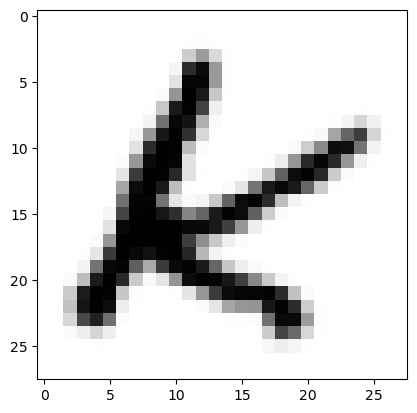

In [35]:
plt.imshow(np.reshape(x, (28,28)), cmap="Greys")
plt.show()

In [6]:
v = 1
w = vertices(2)
c = 10
k = partial(Gaussian_kernel, sigma2=10)
y_pred = hybrid(X_train_2, y_train_2, X_test_2, v, w, c, k)

In [19]:
within_class_error(y_test_2, y_pred)

0.8277511961722488

In [16]:
y_test_2 = y_test_2 + 1

In [20]:
np.unique(y_pred[y_test_2 == 0], return_counts=True)

(array([-1,  0]), array([101, 108]))

In [21]:
np.unique(y_pred[y_test_2 == 1], return_counts=True)

(array([-1]), array([192]))

In [22]:
np.unique(y_pred[y_test_2 == 45], return_counts=True)

(array([-1]), array([572]))

In [13]:
k = partial(Gaussian_kernel, sigma2=10)
model = one_class_svm(X_test_2, v=0.1, K=k)

In [1]:
from sklearn import svm

In [5]:
model = svm.OneClassSVM(kernel='rbf', gamma='scale', nu=0.2)
model.fit(X_test)
y_pred = model.predict(X_test)